<a href="https://colab.research.google.com/github/haoboooo/Temporal-Effect-of-Sentiment-Analysis/blob/main/software_AdapterFusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
!pip install emot
!pip install -U adapter-transformers
!pip install datasets

In [82]:
import pandas as pd
import numpy as np
import string
import os

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score

import torch
from transformers import RobertaTokenizer
import datasets
from datasets import Dataset
from transformers import RobertaConfig, RobertaModelWithHeads
from transformers import TrainingArguments, AdapterTrainer, EvalPrediction

In [83]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## load software data

In [84]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/software/98_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/software/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/software/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/software/18.csv"

In [85]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(27028, 3)
 1.0    13613
-1.0    11120
 0.0     2295
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,-Great devotional Bible written with easy-to-u...
1,1.0,2006,I love the new king james version of the the l...
2,1.0,2005,I highly recommend this version of the bible f...
3,1.0,2005,This Bible is a great study help. The comment...
4,1.0,2005,Great Bible for study - very informative and t...


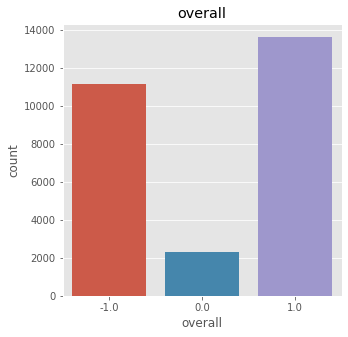

In [86]:
# load data for 1998 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(83773, 3)
 1.0    48362
-1.0    27920
 0.0     7491
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2011,"Strong backgroung, good read, quite up to date..."
1,0.0,2010,If you live on Mars and never heard of the int...
2,1.0,2010,i got this book on amazon and it ended up savi...
3,1.0,2010,I was very happy with this purchase because th...
4,1.0,2010,Recieved in a timely manner- book in great con...


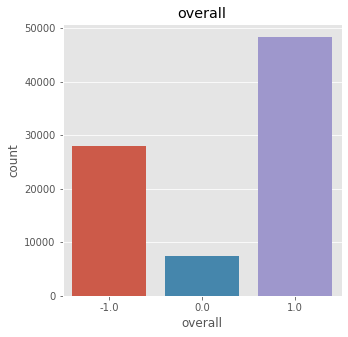

In [87]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

(235021, 3)
 1.0    146179
-1.0     69066
 0.0     19776
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2014,The materials arrived early and were in excell...
1,1.0,2014,I am really enjoying this book with the worksh...
2,-1.0,2014,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ..."
3,0.0,2014,This book was missing pages!!! Important pages...
4,1.0,2013,I have used LearnSmart and can officially say ...


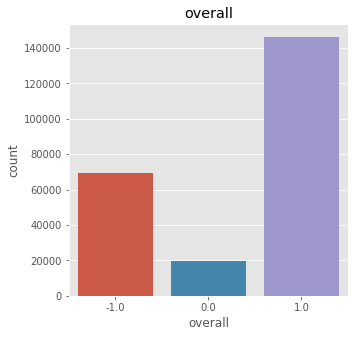

In [88]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(10435, 3)
 1.0    5925
-1.0    3732
 0.0     778
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,-1.0,2018,Product had false key. Fake Microsoft phone n...
1,1.0,2018,the codes worked fine. Im not really a fan of...
2,1.0,2018,This product was good i loved that i was able ...
3,1.0,2018,It is just a must have for your computer what ...
4,1.0,2018,Having access on more than one device helps.


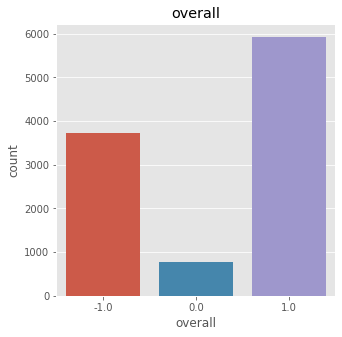

In [89]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

Balance each time period for 
5900 positive，3700 negative，770 neutral

80%(8056) training and 20%(2314) testing

In [90]:
def split_balance(df):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # split to get train for each class
  train_posdata = pos.iloc[:4480,:]
  train_neudata = neu.iloc[:616,:]
  train_negdata = neg.iloc[:2960,:]

  # split to get test for each class
  test_posdata = pos.iloc[4480:5900,:]
  test_neudata = neu.iloc[616:770,:]
  test_negdata = neg.iloc[2960:3700,:]

  train = pd.concat([train_posdata, train_neudata, train_negdata],sort=False).sample(frac=1.0)
  test = pd.concat([test_posdata, test_neudata, test_negdata],sort=False).sample(frac=1.0)

  return train,test

In [91]:
# data for 1998 - 2006
df1_train,df1_test = split_balance(df1)

# data for 2007 - 2012
df2_train,df2_test = split_balance(df2)

# data for 2013 - 2017
df3_train,df3_test = split_balance(df3)

# data for 2018
df4_train,df4_test = split_balance(df4)

In [92]:
df1_train["overall"] = df1_train["overall"].replace(-1,2)
df1_test["overall"] = df1_test["overall"].replace(-1,2)

df2_train["overall"] = df2_train["overall"].replace(-1,2)
df2_test["overall"] = df2_test["overall"].replace(-1,2)

df3_train["overall"] = df3_train["overall"].replace(-1,2)
df3_test["overall"] = df3_test["overall"].replace(-1,2)

df4_train["overall"] = df4_train["overall"].replace(-1,2)
df4_test["overall"] = df4_test["overall"].replace(-1,2)

In [93]:
df1_train.head()

,overall,reviewTime,reviewText
23563,0.0,2004,I previously gave this product 2 stars because...
15597,0.0,2006,This year's version of TaxCut omitted the feat...
15871,1.0,2006,I can't believe they hadn't organized Turbo Ta...
3897,0.0,2002,The beige G3 desktops are supposed to be suppo...
26878,1.0,2000,The Windows NT Server 4.0 Upgrade proves that ...


## Text Preprocessing

In [94]:
# get stopwords from txt
def get_stop_words(txt):
    #read the stop words
    with open(txt,'r') as f:
        stopwords_list=f.readlines()
    for i in range (0,len(stopwords_list)):
        stopwords_list[i]=stopwords_list[i].replace('\n','')
    return stopwords_list

In [95]:
# Defining my NLTK stop words and my user-defined stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase) # 26 letters with lowercase
user_stop_words = get_stop_words("./drive/MyDrive/Colab Notebooks/CL/stopwords.txt")
stop_words = stop_words+alphabets+user_stop_words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [96]:
def processtext(txt):
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  
  txt = txt.replace('\r', '').replace('\n', ' ')
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace digits with no space
  txt = re.sub(r"\d", '',txt)
  # convert tweet to lower case
  txt = txt.lower()
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  txt = txt.replace('$','').replace('&','')
  # remove whitespace
  txt = txt.strip()

  tokens = word_tokenize(txt)
  filtered_words = [w for w in tokens if w not in stop_words]
  # filtered_words = [w for w in filtered_words if w in word_list]
  return " ".join(filtered_words)

In [97]:
df1_train["cleanText"] = df1_train["reviewText"].apply(processtext)
df1_test["cleanText"] = df1_test["reviewText"].apply(processtext)

df2_train["cleanText"] = df2_train["reviewText"].apply(processtext)
df2_test["cleanText"] = df2_test["reviewText"].apply(processtext)

df3_train["cleanText"] = df3_train["reviewText"].apply(processtext)
df3_test["cleanText"] = df3_test["reviewText"].apply(processtext)

df4_train["cleanText"] = df4_train["reviewText"].apply(processtext)
df4_test["cleanText"] = df4_test["reviewText"].apply(processtext)

## Tokenization

In [98]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def encode_batch(batch):
  """Encodes a batch of input data using the model tokenizer."""
  return tokenizer(batch["text"], max_length=128, truncation=True, padding="max_length")

loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/roberta-base/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd

In [99]:
def generate_datasetdict(dataframe1,dataframe2):
  text1 = dataframe1.cleanText.values
  text2 = dataframe2.cleanText.values

  label1 = dataframe1.overall.values.astype(np.int32)
  label2 = dataframe2.overall.values.astype(np.int32)

  train_df = pd.DataFrame({"label" : label1,"text" : text1})
  test_df = pd.DataFrame({"label" : label2,"text" : text2})

  train_dataset = Dataset.from_dict(train_df)
  test_dataset = Dataset.from_dict(test_df)
  my_dataset_dict = datasets.DatasetDict({"train":train_dataset,"test":test_dataset})

  # Encode the input data
  dataset = my_dataset_dict.map(encode_batch, batched=True)
  # The transformers model expects the target class column to be named "labels"
  # dataset.rename_column(original_column_name="label", new_column_name="labels")
  # Transform to pytorch tensors and only output the required columns
  dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

  return dataset

In [100]:
df1_dataset = generate_datasetdict(df1_train,df1_test)
df2_dataset = generate_datasetdict(df2_train,df2_test)
df3_dataset = generate_datasetdict(df3_train,df3_test)
df4_dataset = generate_datasetdict(df4_train,df4_test)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

## Train Adapters

### adapter learning from 1998-2006

In [101]:
config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [102]:
# Add a new adapter
model.add_adapter("df1")
# Add a matching classification head
model.add_classification_head(
    "reviews",
    num_labels=3,
    id2label={ 0: "neutral", 1: "positive", 2: "negative"}
  )
# Activate the adapter
model.train_adapter("df1")

Adding adapter 'df1'.
Adding head 'reviews' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'neutral': 0, 'positive': 1, 'negative': 2}, 'use_pooler': False, 'bias': True}.


In [103]:
training_args = TrainingArguments(
    learning_rate=1e-4,
    num_train_epochs=6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=200,
    output_dir="./training_output",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
)

def compute_accuracy(p: EvalPrediction):
  preds = np.argmax(p.predictions, axis=1)
  return {"acc": (preds == p.label_ids).mean()}

df1_trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=df1_dataset["train"],
    eval_dataset=df1_dataset["test"],
    compute_metrics=compute_accuracy,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [104]:
df1_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8056
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1512


Step,Training Loss
200,0.717600
400,0.539100
600,0.515800
800,0.476500
1000,0.462900
1200,0.442400
1400,0.429000


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-500/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-1000/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1500
Configuration saved in ./training_output/checkpoint-1500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-1500/df1/pytorch_ada

TrainOutput(global_step=1512, training_loss=0.5061186356519265, metrics={'train_runtime': 409.4725, 'train_samples_per_second': 118.045, 'train_steps_per_second': 3.693, 'total_flos': 3234593235750912.0, 'train_loss': 0.5061186356519265, 'epoch': 6.0})

In [105]:
df1_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2314
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.8301642178046672,
 'eval_loss': 0.47285792231559753,
 'eval_runtime': 9.6484,
 'eval_samples_per_second': 239.831,
 'eval_steps_per_second': 7.566}

In [106]:
df1_trainer.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-1.1625416 ,  2.2236314 , -1.0186388 ],
       [-1.1115912 ,  2.8180017 , -1.5414975 ],
       [ 0.13191146,  1.4424473 , -1.4023501 ],
       ...,
       [-0.6748421 ,  2.9411423 , -2.1591487 ],
       [-0.7464173 , -1.8548559 ,  2.191404  ],
       [-1.6861349 ,  4.4319844 , -2.6057131 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 0, 1]), metrics={'test_loss': 0.45571038126945496, 'test_acc': 0.8392394122731202, 'test_runtime': 9.664, 'test_samples_per_second': 239.444, 'test_steps_per_second': 7.554})

In [107]:
df1_trainer.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-1.5587634 ,  0.79080135,  0.73525786],
       [-2.229517  ,  4.2082872 , -2.0090404 ],
       [-0.9640384 ,  1.4774555 , -0.3531496 ],
       ...,
       [-1.1964582 ,  0.91508883,  0.17012693],
       [-1.4633099 , -2.1622775 ,  3.387453  ],
       [-0.5092829 ,  3.0299778 , -2.4269516 ]], dtype=float32), label_ids=array([1, 1, 2, ..., 1, 2, 1]), metrics={'test_loss': 0.45666900277137756, 'test_acc': 0.8314606741573034, 'test_runtime': 9.6572, 'test_samples_per_second': 239.613, 'test_steps_per_second': 7.559})

In [108]:
df1_trainer.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-1.8771569 ,  0.7023218 ,  0.99315137],
       [-0.6184559 ,  0.6528787 ,  0.06962863],
       [-1.706993  ,  0.10162245,  1.524683  ],
       ...,
       [-0.01328074,  1.4710034 , -1.434864  ],
       [-1.2819651 , -2.600973  ,  3.5668423 ],
       [-1.1009684 ,  2.9983053 , -1.8338052 ]], dtype=float32), label_ids=array([2, 1, 2, ..., 1, 2, 1]), metrics={'test_loss': 0.49241936206817627, 'test_acc': 0.8111495246326706, 'test_runtime': 9.6552, 'test_samples_per_second': 239.663, 'test_steps_per_second': 7.561})

In [109]:
model.save_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/1", "df1")

Configuration saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/1/adapter_config.json
Module weights saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/1/pytorch_adapter.bin


In [110]:
model.delete_adapter('df1')

### adapter learning from 2007-2012

In [111]:
model.add_adapter("df2")

Adding adapter 'df2'.


In [112]:
# Activate the adapter
model.train_adapter("df2")

In [113]:
df2_trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=df2_dataset["train"],
    eval_dataset=df2_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [114]:
df2_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8056
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1512


Step,Training Loss
200,0.644800
400,0.549000
600,0.497900
800,0.472900
1000,0.475600
1200,0.455200
1400,0.424900


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-500/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-1000/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1500
Configuration saved in ./training_output/checkpoint-1500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-1500/df2/pytorch_ada

TrainOutput(global_step=1512, training_loss=0.4992866490883802, metrics={'train_runtime': 401.4834, 'train_samples_per_second': 120.394, 'train_steps_per_second': 3.766, 'total_flos': 3234593235750912.0, 'train_loss': 0.4992866490883802, 'epoch': 6.0})

In [115]:
df2_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2314
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.851771823681936,
 'eval_loss': 0.43642017245292664,
 'eval_runtime': 9.6318,
 'eval_samples_per_second': 240.246,
 'eval_steps_per_second': 7.579}

In [116]:
df2_trainer.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-0.60031956,  3.3754687 , -2.482405  ],
       [-1.32583   ,  2.7303908 , -1.3618429 ],
       [-1.6045007 ,  4.2812753 , -2.270098  ],
       ...,
       [-2.5075934 ,  3.9827852 , -1.1810076 ],
       [-0.55970806,  1.6053537 , -0.6714981 ],
       [-0.72588706, -1.5286461 ,  2.2342298 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 1, 2]), metrics={'test_loss': 0.46368128061294556, 'test_acc': 0.8301642178046672, 'test_runtime': 9.6296, 'test_samples_per_second': 240.301, 'test_steps_per_second': 7.581})

In [117]:
df2_trainer.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-0.41802037,  0.8268214 , -0.31261978],
       [-1.9959295 ,  4.999931  , -2.8995495 ],
       [-0.464625  ,  0.91062623, -0.09974197],
       ...,
       [-0.67346483,  0.78407544,  0.0631516 ],
       [-0.55424434, -2.019688  ,  2.5556839 ],
       [-0.2601457 ,  3.0518568 , -2.4932418 ]], dtype=float32), label_ids=array([1, 1, 2, ..., 1, 2, 1]), metrics={'test_loss': 0.44631391763687134, 'test_acc': 0.8284356093344858, 'test_runtime': 9.638, 'test_samples_per_second': 240.091, 'test_steps_per_second': 7.574})

In [118]:
df2_trainer.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-1.187856  ,  0.32663202,  0.86093307],
       [-1.0270061 ,  2.2287896 , -0.95399964],
       [-1.601129  ,  2.8382008 , -0.90919346],
       ...,
       [ 0.5496127 ,  1.0081486 , -1.3758491 ],
       [-0.62163025, -3.3069046 ,  3.7144334 ],
       [-1.1765882 ,  2.693837  , -1.3993146 ]], dtype=float32), label_ids=array([2, 1, 2, ..., 1, 2, 1]), metrics={'test_loss': 0.46362271904945374, 'test_acc': 0.8271391529818496, 'test_runtime': 9.8197, 'test_samples_per_second': 235.649, 'test_steps_per_second': 7.434})

In [119]:
model.save_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/2", "df2")

Configuration saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/2/adapter_config.json
Module weights saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/2/pytorch_adapter.bin


In [120]:
model.delete_adapter('df2')

### adapter learning from 2013-2017

In [121]:
model.add_adapter("df3")

Adding adapter 'df3'.


In [122]:
# Activate the adapter
model.train_adapter("df3")

In [123]:
df3_trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=df3_dataset["train"],
    eval_dataset=df3_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [124]:
df3_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8056
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1512


Step,Training Loss
200,0.636200
400,0.545400
600,0.518700
800,0.486500
1000,0.481200
1200,0.472300
1400,0.453600


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-500/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-1000/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1500
Configuration saved in ./training_output/checkpoint-1500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-1500/df3/pytorch_ada

TrainOutput(global_step=1512, training_loss=0.5095826860458131, metrics={'train_runtime': 401.2183, 'train_samples_per_second': 120.473, 'train_steps_per_second': 3.769, 'total_flos': 3234593235750912.0, 'train_loss': 0.5095826860458131, 'epoch': 6.0})

In [125]:
df3_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2314
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.8327571305099395,
 'eval_loss': 0.42163944244384766,
 'eval_runtime': 9.6407,
 'eval_samples_per_second': 240.024,
 'eval_steps_per_second': 7.572}

In [126]:
df3_trainer.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-0.6808407 ,  2.6892216 , -1.787394  ],
       [-0.9041019 ,  2.2302494 , -1.3091291 ],
       [-1.6210705 ,  3.4987047 , -1.5708885 ],
       ...,
       [-2.3012848 ,  3.4629152 , -0.92596817],
       [-0.7250536 ,  1.6727428 , -0.68297035],
       [-1.0110582 , -1.0627451 ,  2.014139  ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 1, 2]), metrics={'test_loss': 0.48372989892959595, 'test_acc': 0.8176318063958513, 'test_runtime': 9.6237, 'test_samples_per_second': 240.448, 'test_steps_per_second': 7.585})

In [127]:
df3_trainer.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-1.3708497 ,  1.8652234 , -0.3787965 ],
       [-1.1644677 ,  3.8821924 , -2.326316  ],
       [-0.19018966,  0.78980666, -0.39843324],
       ...,
       [-0.70774835,  2.4844687 , -1.580509  ],
       [-0.46879202, -1.2385284 ,  1.6303805 ],
       [-1.9470936 ,  3.9614894 , -1.8131021 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 0, 1]), metrics={'test_loss': 0.4468216001987457, 'test_acc': 0.8418323249783924, 'test_runtime': 9.6443, 'test_samples_per_second': 239.934, 'test_steps_per_second': 7.569})

In [128]:
df3_trainer.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-1.5820087 , -1.0947478 ,  2.5870662 ],
       [-0.96430916,  2.6637766 , -1.413857  ],
       [-1.6198553 ,  2.3502064 , -0.5000669 ],
       ...,
       [ 0.6984063 ,  0.86994064, -1.3933492 ],
       [-1.1794903 , -2.7338967 ,  3.6756437 ],
       [-1.2759043 ,  2.6630914 , -1.240366  ]], dtype=float32), label_ids=array([2, 1, 2, ..., 1, 2, 1]), metrics={'test_loss': 0.4434957802295685, 'test_acc': 0.8375108038029386, 'test_runtime': 9.6239, 'test_samples_per_second': 240.444, 'test_steps_per_second': 7.585})

In [129]:
model.save_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/3", "df3")

Configuration saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/3/adapter_config.json
Module weights saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/3/pytorch_adapter.bin


In [130]:
model.delete_adapter('df3')

### adapter learning from 2018

In [131]:
model.add_adapter("df4")

Adding adapter 'df4'.


In [132]:
# Activate the adapter
model.train_adapter("df4")

In [133]:
df4_trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=df4_dataset["train"],
    eval_dataset=df4_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [134]:
df4_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8056
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1512


Step,Training Loss
200,0.626600
400,0.514700
600,0.503600
800,0.491400
1000,0.457600
1200,0.456100
1400,0.435900


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df4/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df4/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-500/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1000
Configuration saved in ./training_output/checkpoint-1000/df4/adapter_config.json
Module weights saved in ./training_output/checkpoint-1000/df4/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-1000/reviews/head_config.json
Module weights saved in ./training_output/checkpoint-1000/reviews/pytorch_model_head.bin
Saving model checkpoint to ./training_output/checkpoint-1500
Configuration saved in ./training_output/checkpoint-1500/df4/adapter_config.json
Module weights saved in ./training_output/checkpoint-1500/df4/pytorch_ada

TrainOutput(global_step=1512, training_loss=0.49379331346542116, metrics={'train_runtime': 401.0909, 'train_samples_per_second': 120.511, 'train_steps_per_second': 3.77, 'total_flos': 3234593235750912.0, 'train_loss': 0.49379331346542116, 'epoch': 6.0})

In [135]:
df4_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2314
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.841400172860847,
 'eval_loss': 0.4267846643924713,
 'eval_runtime': 9.6175,
 'eval_samples_per_second': 240.602,
 'eval_steps_per_second': 7.59}

In [136]:
df4_trainer.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-0.4521924 ,  2.3513415 , -1.9579949 ],
       [-0.9747711 ,  2.1753612 , -1.3784403 ],
       [-1.3870015 ,  2.8704455 , -1.4487585 ],
       ...,
       [-1.910434  ,  2.9005501 , -1.0744417 ],
       [-0.85682094,  1.436274  , -0.5566213 ],
       [-0.5080469 , -1.1922296 ,  1.3595091 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 1, 2]), metrics={'test_loss': 0.49738165736198425, 'test_acc': 0.8115816767502161, 'test_runtime': 9.6126, 'test_samples_per_second': 240.726, 'test_steps_per_second': 7.594})

In [137]:
df4_trainer.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-1.0363369 ,  1.7404248 , -0.87493736],
       [-0.8166841 ,  2.486284  , -1.6738013 ],
       [ 0.05624617,  1.0667666 , -1.1531283 ],
       ...,
       [-0.6490399 ,  2.1534238 , -1.4741157 ],
       [-0.345565  , -1.5204724 ,  1.5128449 ],
       [-1.8021767 ,  4.0866923 , -2.3051176 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 0, 1]), metrics={'test_loss': 0.4554121494293213, 'test_acc': 0.8366464995678479, 'test_runtime': 9.6081, 'test_samples_per_second': 240.839, 'test_steps_per_second': 7.598})

In [138]:
df4_trainer.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-0.99510556,  1.5409325 , -0.63710815],
       [-1.9877393 ,  4.3290067 , -2.3905833 ],
       [-0.7489558 ,  0.87495387, -0.09224816],
       ...,
       [-0.9758311 , -0.2437761 ,  1.0631175 ],
       [-1.1278691 , -1.8434836 ,  2.641864  ],
       [-0.42039135,  2.5169525 , -2.1619031 ]], dtype=float32), label_ids=array([1, 1, 2, ..., 1, 2, 1]), metrics={'test_loss': 0.4395924508571625, 'test_acc': 0.8349178910976663, 'test_runtime': 9.6123, 'test_samples_per_second': 240.732, 'test_steps_per_second': 7.594})

In [139]:
model.save_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/4", "df4")

Configuration saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/4/adapter_config.json
Module weights saved in ./drive/MyDrive/Colab Notebooks/CL/adapters/4/pytorch_adapter.bin


In [140]:
model.delete_adapter('df4')

## Adapter Fusion

### learn from 1998-2006

In [141]:
config_fu = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model_fu = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config_fu,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [142]:
from transformers.adapters.composition import Fuse
# Load the pre-trained adapters we want to fuse
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/1", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/2", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/3", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/4", with_head=False)

Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/1/adapter_config.json
Adding adapter 'df1'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/1/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/2/adapter_config.json
Adding adapter 'df2'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/2/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/3/adapter_config.json
Adding adapter 'df3'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/3/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/4/adapter_config.json
Adding adapter 'df4'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/4/pytorch_adapter.bin


'df4'

In [143]:
# Add a fusion layer for all loaded adapters
model_fu.add_adapter_fusion(Fuse("df1", "df2", "df3", "df4"))
model_fu.set_active_adapters(Fuse("df1", "df2", "df3", "df4"))

Adding AdapterFusion 'df1,df2,df3,df4'.
Could not identify a valid prediction head from setup 'Fuse[df1, df2, df3, df4]'.


In [144]:
# Add a classification head for our target task
model_fu.add_classification_head("fusion", num_labels=3)

Adding head 'fusion' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}, 'use_pooler': False, 'bias': True}.


In [145]:
# Unfreeze and activate fusion setup
adapter_setup = Fuse("df1", "df2", "df3", "df4")
model_fu.train_adapter_fusion(adapter_setup)

In [146]:
fusion_trainer_df1 = AdapterTrainer(
    model=model_fu,
    args=training_args,
    train_dataset=df1_dataset["train"],
    eval_dataset=df1_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [147]:
fusion_trainer_df1.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8056
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1512


Step,Training Loss
200,0.502500
400,0.471300
600,0.459800
800,0.443000
1000,0.428300
1200,0.423700
1400,0.409400


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df4/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df4/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df1,df2,df3,df4/adapter_fusion_config.json
Module weights saved in ./training_output/checkpoint-500/df1,df2,df3,df4/pytorch_model_adapter_fusion.bin
Configuration saved in ./training_output/checkpoint-500/fusion/head_config.json
Module weig

TrainOutput(global_step=1512, training_loss=0.44583890047022906, metrics={'train_runtime': 867.5261, 'train_samples_per_second': 55.717, 'train_steps_per_second': 1.743, 'total_flos': 4123134697623552.0, 'train_loss': 0.44583890047022906, 'epoch': 6.0})

In [148]:
fusion_trainer_df1.evaluate()

***** Running Evaluation *****
  Num examples = 2314
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.8336214347450303,
 'eval_loss': 0.4729347229003906,
 'eval_runtime': 16.9654,
 'eval_samples_per_second': 136.395,
 'eval_steps_per_second': 4.303}

In [149]:
fusion_trainer_df1.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-1.4082565 ,  2.404271  , -1.3614854 ],
       [-1.4012301 ,  2.7328887 , -1.7997977 ],
       [-0.04910264,  1.1968473 , -1.5393485 ],
       ...,
       [-0.86740685,  2.8514533 , -2.5471501 ],
       [-0.84036523, -1.6794579 ,  2.1088238 ],
       [-1.8944985 ,  4.3996263 , -2.893577  ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 0, 1]), metrics={'test_loss': 0.4537785053253174, 'test_acc': 0.841400172860847, 'test_runtime': 16.9995, 'test_samples_per_second': 136.121, 'test_steps_per_second': 4.294})

In [150]:
fusion_trainer_df1.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-1.8225105 ,  0.98836774,  0.65140355],
       [-2.3208344 ,  4.0294666 , -2.0915403 ],
       [-1.4332769 ,  1.2031273 , -0.210894  ],
       ...,
       [-1.2012036 ,  0.7170282 ,  0.25960103],
       [-1.6697817 , -2.0788257 ,  3.1865544 ],
       [-0.56771237,  2.9755862 , -2.6423311 ]], dtype=float32), label_ids=array([1, 1, 2, ..., 1, 2, 1]), metrics={'test_loss': 0.4609016180038452, 'test_acc': 0.8292999135695764, 'test_runtime': 16.9719, 'test_samples_per_second': 136.343, 'test_steps_per_second': 4.301})

In [151]:
fusion_trainer_df1.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-1.8051295 ,  0.55680436,  1.0373763 ],
       [-1.0344718 ,  0.28913587,  0.24956831],
       [-1.9140582 , -0.6073321 ,  2.2946837 ],
       ...,
       [-0.17388164,  1.3450583 , -1.5268558 ],
       [-1.3985319 , -2.4721415 ,  3.613014  ],
       [-0.75655484,  2.6223085 , -1.9965883 ]], dtype=float32), label_ids=array([2, 1, 2, ..., 1, 2, 1]), metrics={'test_loss': 0.4919828176498413, 'test_acc': 0.8124459809853068, 'test_runtime': 16.9806, 'test_samples_per_second': 136.273, 'test_steps_per_second': 4.299})

### learn from 2007-2012

In [152]:
config_fu = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model_fu = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config_fu,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [153]:
from transformers.adapters.composition import Fuse
# Load the pre-trained adapters we want to fuse
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/1", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/2", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/3", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/4", with_head=False)

Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/1/adapter_config.json
Adding adapter 'df1'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/1/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/2/adapter_config.json
Adding adapter 'df2'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/2/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/3/adapter_config.json
Adding adapter 'df3'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/3/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/4/adapter_config.json
Adding adapter 'df4'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/4/pytorch_adapter.bin


'df4'

In [154]:
# Add a fusion layer for all loaded adapters
model_fu.add_adapter_fusion(Fuse("df1", "df2", "df3", "df4"))
model_fu.set_active_adapters(Fuse("df1", "df2", "df3", "df4"))
# Add a classification head for our target task
model_fu.add_classification_head("fusion", num_labels=3)
# Unfreeze and activate fusion setup
adapter_setup = Fuse("df1", "df2", "df3", "df4")
model_fu.train_adapter_fusion(adapter_setup)

Adding AdapterFusion 'df1,df2,df3,df4'.
Could not identify a valid prediction head from setup 'Fuse[df1, df2, df3, df4]'.
Adding head 'fusion' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}, 'use_pooler': False, 'bias': True}.


In [155]:
fusion_trainer_df2 = AdapterTrainer(
    model=model_fu,
    args=training_args,
    train_dataset=df2_dataset["train"],
    eval_dataset=df2_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [156]:
fusion_trainer_df2.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8056
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1512


Step,Training Loss
200,0.525300
400,0.497700
600,0.466600
800,0.448000
1000,0.455900
1200,0.440400
1400,0.423300


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df4/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df4/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df1,df2,df3,df4/adapter_fusion_config.json
Module weights saved in ./training_output/checkpoint-500/df1,df2,df3,df4/pytorch_model_adapter_fusion.bin
Configuration saved in ./training_output/checkpoint-500/fusion/head_config.json
Module weig

TrainOutput(global_step=1512, training_loss=0.4632683885160577, metrics={'train_runtime': 867.7874, 'train_samples_per_second': 55.7, 'train_steps_per_second': 1.742, 'total_flos': 4123134697623552.0, 'train_loss': 0.4632683885160577, 'epoch': 6.0})

In [157]:
fusion_trainer_df2.evaluate()

***** Running Evaluation *****
  Num examples = 2314
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.851771823681936,
 'eval_loss': 0.43410611152648926,
 'eval_runtime': 16.9868,
 'eval_samples_per_second': 136.223,
 'eval_steps_per_second': 4.297}

In [158]:
fusion_trainer_df2.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-0.7174549 ,  2.8826666 , -2.3716142 ],
       [-1.6744562 ,  2.737893  , -1.4330312 ],
       [-1.7503494 ,  4.1640887 , -2.7420678 ],
       ...,
       [-2.1397054 ,  3.2021096 , -1.2318558 ],
       [-0.65132964,  1.3414567 , -0.80056113],
       [-0.75219345, -1.3545666 ,  2.169665  ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 1, 2]), metrics={'test_loss': 0.4592224955558777, 'test_acc': 0.8323249783923942, 'test_runtime': 16.9644, 'test_samples_per_second': 136.403, 'test_steps_per_second': 4.303})

In [159]:
fusion_trainer_df2.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-0.00856542,  0.6249666 , -0.38176578],
       [-1.7659069 ,  4.1404133 , -2.5151749 ],
       [-0.7037941 ,  0.905763  , -0.10093617],
       ...,
       [-0.75173736,  0.56249446,  0.16113795],
       [-0.7758559 , -1.7775074 ,  2.297946  ],
       [-0.3621825 ,  2.6851165 , -2.421476  ]], dtype=float32), label_ids=array([1, 1, 2, ..., 1, 2, 1]), metrics={'test_loss': 0.44351232051849365, 'test_acc': 0.827571305099395, 'test_runtime': 16.9609, 'test_samples_per_second': 136.432, 'test_steps_per_second': 4.304})

In [160]:
fusion_trainer_df2.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-0.8369958 , -0.00493569,  0.7735677 ],
       [-1.0811905 ,  2.2089427 , -1.2268847 ],
       [-1.6982545 ,  2.441312  , -0.96357983],
       ...,
       [ 0.2669121 ,  1.0669566 , -1.6051601 ],
       [-0.95752275, -2.7566211 ,  3.728106  ],
       [-1.2257342 ,  2.7191734 , -1.6853491 ]], dtype=float32), label_ids=array([2, 1, 2, ..., 1, 2, 1]), metrics={'test_loss': 0.4557555317878723, 'test_acc': 0.8340535868625756, 'test_runtime': 16.9832, 'test_samples_per_second': 136.253, 'test_steps_per_second': 4.298})

### learn from 2013-2017

In [161]:
config_fu = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model_fu = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config_fu,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [162]:
from transformers.adapters.composition import Fuse
# Load the pre-trained adapters we want to fuse
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/1", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/2", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/3", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/4", with_head=False)

Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/1/adapter_config.json
Adding adapter 'df1'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/1/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/2/adapter_config.json
Adding adapter 'df2'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/2/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/3/adapter_config.json
Adding adapter 'df3'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/3/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/4/adapter_config.json
Adding adapter 'df4'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/4/pytorch_adapter.bin


'df4'

In [163]:
# Add a fusion layer for all loaded adapters
model_fu.add_adapter_fusion(Fuse("df1", "df2", "df3", "df4"))
model_fu.set_active_adapters(Fuse("df1", "df2", "df3", "df4"))
# Add a classification head for our target task
model_fu.add_classification_head("fusion", num_labels=3)
# Unfreeze and activate fusion setup
adapter_setup = Fuse("df1", "df2", "df3", "df4")
model_fu.train_adapter_fusion(adapter_setup)

Adding AdapterFusion 'df1,df2,df3,df4'.
Could not identify a valid prediction head from setup 'Fuse[df1, df2, df3, df4]'.
Adding head 'fusion' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}, 'use_pooler': False, 'bias': True}.


In [164]:
fusion_trainer_df3 = AdapterTrainer(
    model=model_fu,
    args=training_args,
    train_dataset=df3_dataset["train"],
    eval_dataset=df3_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [165]:
fusion_trainer_df3.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8056
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1512


Step,Training Loss
200,0.534600
400,0.497500
600,0.490200
800,0.466800
1000,0.473300
1200,0.455300
1400,0.435300


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df4/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df4/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df1,df2,df3,df4/adapter_fusion_config.json
Module weights saved in ./training_output/checkpoint-500/df1,df2,df3,df4/pytorch_model_adapter_fusion.bin
Configuration saved in ./training_output/checkpoint-500/fusion/head_config.json
Module weig

TrainOutput(global_step=1512, training_loss=0.4766047215335584, metrics={'train_runtime': 867.9107, 'train_samples_per_second': 55.692, 'train_steps_per_second': 1.742, 'total_flos': 4123134697623552.0, 'train_loss': 0.4766047215335584, 'epoch': 6.0})

In [166]:
fusion_trainer_df3.evaluate()

***** Running Evaluation *****
  Num examples = 2314
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.8418323249783924,
 'eval_loss': 0.4181751310825348,
 'eval_runtime': 16.9964,
 'eval_samples_per_second': 136.147,
 'eval_steps_per_second': 4.295}

In [167]:
fusion_trainer_df3.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-0.93392754,  2.8202147 , -2.3251665 ],
       [-0.7721972 ,  2.1248221 , -1.7418548 ],
       [-1.8033882 ,  3.4395943 , -2.047955  ],
       ...,
       [-2.2489793 ,  3.0522184 , -1.3211892 ],
       [-1.0509944 ,  1.6670054 , -0.99379545],
       [-1.1285285 , -1.1685852 ,  2.0550125 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 1, 2]), metrics={'test_loss': 0.4719732105731964, 'test_acc': 0.8280034572169404, 'test_runtime': 16.9865, 'test_samples_per_second': 136.226, 'test_steps_per_second': 4.298})

In [168]:
fusion_trainer_df3.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-1.3494785 ,  1.8094395 , -0.8832471 ],
       [-1.4361619 ,  3.9804819 , -2.9200594 ],
       [-0.56905836,  0.910083  , -0.84968305],
       ...,
       [-0.9181476 ,  2.5829124 , -2.0908868 ],
       [-0.62019986, -0.9514598 ,  1.0992098 ],
       [-2.0384207 ,  3.9880974 , -2.3575215 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 0, 1]), metrics={'test_loss': 0.4400365650653839, 'test_acc': 0.8465859982713916, 'test_runtime': 16.9744, 'test_samples_per_second': 136.323, 'test_steps_per_second': 4.301})

In [169]:
fusion_trainer_df3.predict(df4_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-1.7441555 , -1.2164689 ,  2.7757459 ],
       [-1.5523043 ,  3.198266  , -1.9967396 ],
       [-1.8134933 ,  1.7732931 , -0.4479805 ],
       ...,
       [ 0.12420589,  1.2723037 , -1.8493891 ],
       [-1.2552661 , -2.3981586 ,  3.29158   ],
       [-1.5288849 ,  2.9263139 , -1.7820243 ]], dtype=float32), label_ids=array([2, 1, 2, ..., 1, 2, 1]), metrics={'test_loss': 0.4318583309650421, 'test_acc': 0.841400172860847, 'test_runtime': 16.994, 'test_samples_per_second': 136.166, 'test_steps_per_second': 4.296})

### learn from 2018

In [170]:
config_fu = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=3,
)
model_fu = RobertaModelWithHeads.from_pretrained(
    "roberta-base",
    config=config_fu,
)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_v

In [171]:
from transformers.adapters.composition import Fuse
# Load the pre-trained adapters we want to fuse
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/1", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/2", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/3", with_head=False)
model_fu.load_adapter("./drive/MyDrive/Colab Notebooks/CL/adapters/4", with_head=False)

Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/1/adapter_config.json
Adding adapter 'df1'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/1/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/2/adapter_config.json
Adding adapter 'df2'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/2/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/3/adapter_config.json
Adding adapter 'df3'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/3/pytorch_adapter.bin
Loading module configuration from ./drive/MyDrive/Colab Notebooks/CL/adapters/4/adapter_config.json
Adding adapter 'df4'.
Loading module weights from ./drive/MyDrive/Colab Notebooks/CL/adapters/4/pytorch_adapter.bin


'df4'

In [172]:
# Add a fusion layer for all loaded adapters
model_fu.add_adapter_fusion(Fuse("df1", "df2", "df3", "df4"))
model_fu.set_active_adapters(Fuse("df1", "df2", "df3", "df4"))
# Add a classification head for our target task
model_fu.add_classification_head("fusion", num_labels=3)
# Unfreeze and activate fusion setup
adapter_setup = Fuse("df1", "df2", "df3", "df4")
model_fu.train_adapter_fusion(adapter_setup)

Adding AdapterFusion 'df1,df2,df3,df4'.
Could not identify a valid prediction head from setup 'Fuse[df1, df2, df3, df4]'.
Adding head 'fusion' with config {'head_type': 'classification', 'num_labels': 3, 'layers': 2, 'activation_function': 'tanh', 'label2id': {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}, 'use_pooler': False, 'bias': True}.


In [173]:
fusion_trainer_df4 = AdapterTrainer(
    model=model_fu,
    args=training_args,
    train_dataset=df4_dataset["train"],
    eval_dataset=df4_dataset["test"],
    compute_metrics=compute_accuracy,
)

In [174]:
fusion_trainer_df4.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 8056
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1512


Step,Training Loss
200,0.542400
400,0.481400
600,0.465200
800,0.457000
1000,0.444400
1200,0.442900
1400,0.428600


Saving model checkpoint to ./training_output/checkpoint-500
Configuration saved in ./training_output/checkpoint-500/df1/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df1/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df2/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df2/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df3/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df3/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df4/adapter_config.json
Module weights saved in ./training_output/checkpoint-500/df4/pytorch_adapter.bin
Configuration saved in ./training_output/checkpoint-500/df1,df2,df3,df4/adapter_fusion_config.json
Module weights saved in ./training_output/checkpoint-500/df1,df2,df3,df4/pytorch_model_adapter_fusion.bin
Configuration saved in ./training_output/checkpoint-500/fusion/head_config.json
Module weig

TrainOutput(global_step=1512, training_loss=0.4635431526829957, metrics={'train_runtime': 868.1335, 'train_samples_per_second': 55.678, 'train_steps_per_second': 1.742, 'total_flos': 4123134697623552.0, 'train_loss': 0.4635431526829957, 'epoch': 6.0})

In [175]:
fusion_trainer_df4.evaluate()

***** Running Evaluation *****
  Num examples = 2314
  Batch size = 32


{'epoch': 6.0,
 'eval_acc': 0.8426966292134831,
 'eval_loss': 0.42364999651908875,
 'eval_runtime': 17.0035,
 'eval_samples_per_second': 136.09,
 'eval_steps_per_second': 4.293}

In [179]:
fusion_trainer_df4.predict(df1_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-0.6518827 ,  2.3503954 , -2.119446  ],
       [-0.97587854,  1.8599441 , -1.4690676 ],
       [-1.8232448 ,  3.1572144 , -1.7659684 ],
       ...,
       [-1.8463546 ,  3.1021945 , -1.764793  ],
       [-0.86707425,  1.022579  , -0.44483978],
       [-0.47579318, -1.0650231 ,  1.3972322 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 1, 2]), metrics={'test_loss': 0.49774712324142456, 'test_acc': 0.8184961106309421, 'test_runtime': 16.9941, 'test_samples_per_second': 136.165, 'test_steps_per_second': 4.296})

In [180]:
fusion_trainer_df4.predict(df2_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-1.1253932 ,  1.8768129 , -1.0824236 ],
       [-1.1793847 ,  3.0735788 , -2.340535  ],
       [-0.24816336,  1.0878793 , -1.3082501 ],
       ...,
       [-1.1382875 ,  2.3624537 , -1.877379  ],
       [-0.53790516, -1.2413596 ,  1.3715876 ],
       [-1.7735088 ,  3.8861692 , -2.5903208 ]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 0, 1]), metrics={'test_loss': 0.45210000872612, 'test_acc': 0.8444252376836646, 'test_runtime': 17.0112, 'test_samples_per_second': 136.028, 'test_steps_per_second': 4.291})

In [181]:
fusion_trainer_df4.predict(df3_dataset["test"])

***** Running Prediction *****
  Num examples = 2314
  Batch size = 32


PredictionOutput(predictions=array([[-1.058133  ,  0.41355067,  0.37581477],
       [-2.289572  ,  4.1718225 , -2.1965268 ],
       [-1.1133144 ,  1.4511557 , -0.59230375],
       ...,
       [-1.1359804 ,  0.02583293,  0.80209154],
       [-1.0797949 , -1.9848216 ,  2.6543937 ],
       [-0.5570972 ,  2.6185102 , -2.3707473 ]], dtype=float32), label_ids=array([1, 1, 2, ..., 1, 2, 1]), metrics={'test_loss': 0.4429880976676941, 'test_acc': 0.8327571305099395, 'test_runtime': 17.0293, 'test_samples_per_second': 135.884, 'test_steps_per_second': 4.287})